# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.998424,False,3.095450
1,1.403003,False,2.597003
2,0.674959,True,5.161427
3,0.712088,True,6.959883
4,0.224879,True,5.553278
...,...,...,...
995,-0.217725,True,5.382402
996,0.392778,False,0.511274
997,-0.847266,True,3.229490
998,0.189334,False,-0.662626


<AxesSubplot: xlabel='v0'>

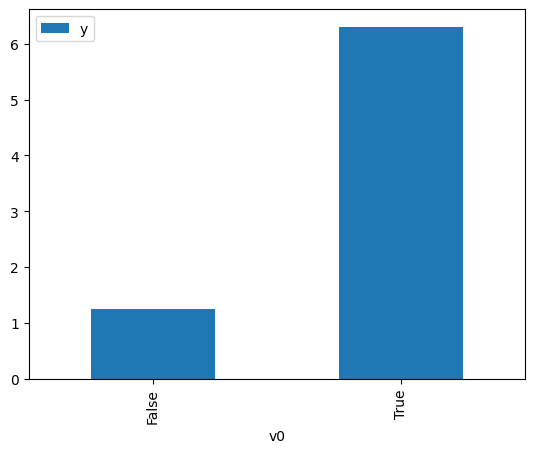

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

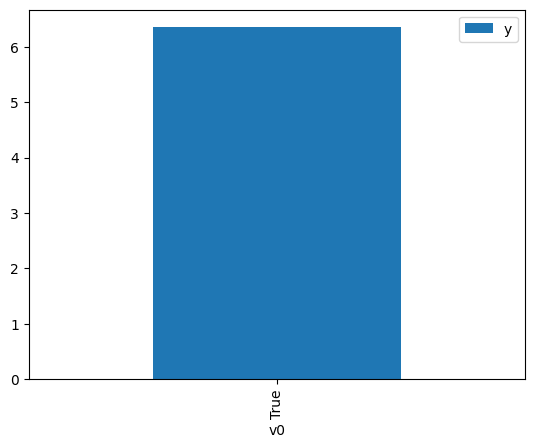

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,0.918054,False,1.993549,0.428390,2.334320
1,0.503966,False,0.530631,0.457035,2.188016
2,2.029441,False,4.925447,0.354315,2.822347
3,0.455598,False,-0.071221,0.460403,2.172009
4,3.633791,False,8.978977,0.259208,3.857901
...,...,...,...,...,...
995,0.611965,False,-0.266216,0.449529,2.224551
996,1.997070,False,4.527194,0.356395,2.805877
997,2.079082,False,3.478149,0.351136,2.847896
998,1.227414,False,3.082318,0.407289,2.455262


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,0.416682,True,5.384697,0.536884,1.862600
1,0.321290,True,6.268089,0.530226,1.885989
2,-0.076509,True,6.670354,0.502371,1.990562
3,0.362243,True,6.829831,0.533086,1.875871
4,1.098488,True,7.375845,0.583954,1.712463
...,...,...,...,...,...
995,1.063069,True,5.343131,0.581539,1.719576
996,-0.097900,True,3.621210,0.500871,1.996523
997,1.136769,True,6.955116,0.586560,1.704855
998,3.560370,True,11.026228,0.736818,1.357187


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.969
Model:                            OLS   Adj. R-squared (uncentered):              0.969
Method:                 Least Squares   F-statistic:                          1.546e+04
Date:                Wed, 19 Oct 2022   Prob (F-statistic):                        0.00
Time:                        14:24:22   Log-Likelihood:                         -1381.8
No. Observations:                1000   AIC:                                      2768.
Df Residuals:                     998   BIC:                                      2777.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.0849      0.029     71.874      0.000       2.028       2.142
x2             4.9724      0.047    106.257      0.000       4.881       5.064
==============================================================================
Omnibus:                        0.738   Durbin-Watson:                   1.880
Prob(Omnibus):                  0.691   Jarque-Bera (JB):                0.609
Skew:                           0.009   Prob(JB):                        0.737
Kurtosis:                       3.119   Cond. No.                         2.06
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""